In [1]:
# Histograms for interphase vs. mitotic matched datasets.

In [2]:
!date
!pwd

Tue Jul  5 14:13:59 PDT 2022
/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMitosis


In [3]:
import os
import sys
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape, control.get_staging())

(202847, 1290) /allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
path_cvapipe = Path(control.get_staging()).parent
datasets = {
    "M1M2": {
        "control": f"{path_cvapipe}/local_staging_variance_m1m2",
        "perturbed": f"{path_cvapipe}/local_staging_m1m2"
    },
    "M3": {
        "control": f"{path_cvapipe}/local_staging_variance_m3",
        "perturbed": f"{path_cvapipe}/local_staging_m3"
    }}

In [7]:
smapper = shapespace.ShapeSpaceMapper(space, output_folder="./")
smapper.use_full_base_dataset()
smapper.set_make_plots_off()
smapper.set_distance_threshold(1e10)
smapper.map(datasets)

	M1M2 loaded. (2201, 1255)
	M3 loaded. (981, 1255)


In [8]:
importlib.reload(plotting)

<module 'cvapipe_analysis.tools.plotting' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/cvapipe_analysis/tools/plotting.py'>

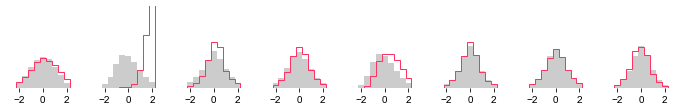

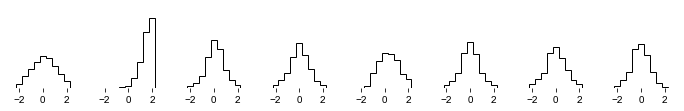

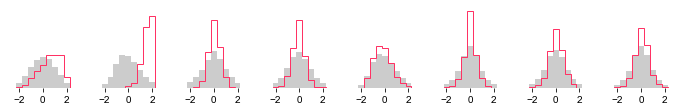

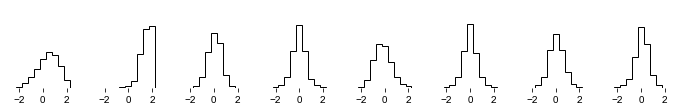

In [9]:
pmaker = plotting.ShapeSpaceMapperPlotMaker(control, "./")
pmaker.set_dataframe(smapper.result)
pmaker.plot_mapping_1d(display_both=False)

In [10]:
for fig, desc in pmaker.figs:
    fig.savefig(f"hists_{desc}.pdf")

### Reconstruct shapes of individual and matched datasets

In [11]:
instances = {}
# Loop over all cells, edge cells and cells from shape matched dataset
for dsname in datasets.keys():
    instances[dsname] = []
    for prefix, suffix in zip(["base", dsname, dsname], ["", "", "_base_matched"]):
        nisos = control.get_number_of_interpolating_points()
        inner_alias = control.get_inner_most_alias_to_parameterize()
        fname = f"avgshape/{prefix}_{inner_alias}{suffix}.vtk"
        inner_mesh = device.read_vtk_polydata(fname)
        outer_alias = control.get_outer_most_alias_to_parameterize()
        fname = f"avgshape/{prefix}_{outer_alias}{suffix}.vtk"
        outer_mesh = device.read_vtk_polydata(fname)
        domain, _ = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])

        domain_nuc = (255*(domain>1)).astype(np.uint8)
        domain_mem = (255*(domain>0)).astype(np.uint8)

        instances[dsname].append(np.stack([domain_nuc, domain_mem, domain_mem], axis=0))

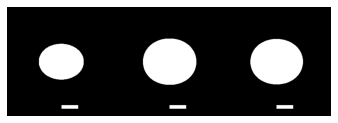

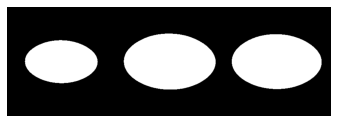

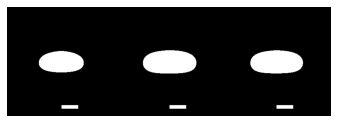

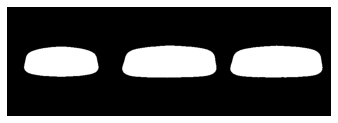

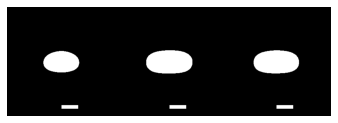

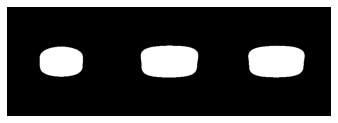

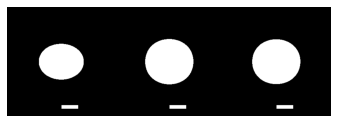

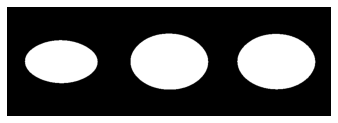

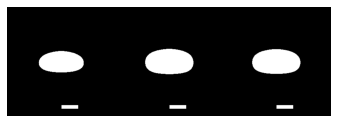

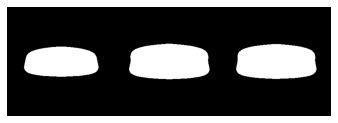

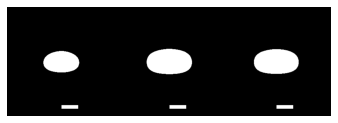

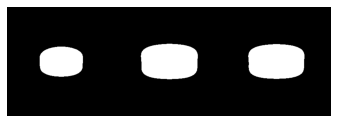

In [12]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
args = {"gridspec_kw": {"hspace": 0, "wspace": -0.1}, "sharex": True, "sharey": True}
for dsname in datasets.keys():
    for orient in ["z", "y", "x"]:
        for alias in ["nuc", "mem"]:
            fig, axs = plt.subplots(1,len(instances[dsname]), figsize=(2*len(instances[dsname]), 2), **args)
            for ax, instance in zip(axs, instances[dsname]):
                ax.axis("off")
                proj = common.Projector(instance, box_size=300)
                proj.set_projection_mode(ax=orient, mode=mode)
                proj.project_on(alias=alias, ax=ax, scale_bar={"pixel_size":0.108, "length":5})
            plt.savefig(f"FigureMitosis1_shapes_{dsname}_{alias}_{orient}.png", dpi=150)
            plt.show()

In [13]:
common.now("complete.")

complete. 2022-07-05 14:16:26
